In [1]:
%pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import LearningRateScheduler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Dropout
from keras import regularizers

# Read all csv files and combine
## These contain continuous time series data

In [2]:
# df_kicks1 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_I_labelled.csv")
# df_kicks2 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_II_labelled.csv")
# df_kicks3 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_III_labelled.csv")

# df_kicks_test = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_test_labelled.csv")
df_kicks1 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_I_labelled2.csv")
df_kicks2 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_II_labelled2.csv")
df_kicks3 = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_III_labelled2.csv")

df_kicks_test = pd.read_csv("/content/drive/MyDrive/DSS/continuous_kicks_test_labelled2.csv")
all_kicks = pd.concat([df_kicks1, df_kicks2, df_kicks3], axis=0)
all_kicks.reset_index(drop=True, inplace=True)

In [ ]:
all_kicks

,time,ax,ay,az,am,rx,ry,rz,rm,movement
0,0.000005,-0.967285,0.018799,0.232910,0.993857,3.448486,3.631592,-0.671387,5.211005,0
1,0.342938,-0.970947,0.046387,0.266113,1.005671,3.997803,2.105713,-0.457764,4.283998,0
2,0.362382,-0.965332,0.064941,0.248047,0.988421,2.716064,1.892090,0.061035,3.610631,0
3,0.381505,-0.943604,0.056396,0.244385,0.984302,3.997803,2.777100,-0.457764,5.022066,0
4,0.400617,-0.972900,0.059082,0.247803,1.016512,5.950928,1.922607,-1.098633,6.351470,0
...,...,...,...,...,...,...,...,...,...,...
26594,157.276149,-0.977295,0.080566,0.147217,0.988574,0.122070,2.014160,0.732422,2.390522,0
26595,157.293291,-0.972900,0.076416,0.152344,0.991101,0.549316,2.319336,0.579834,2.573086,0
26596,157.310528,-0.988037,0.072998,0.143311,1.001748,0.732422,1.586914,0.427246,1.997911,0
26597,157.327724,-0.974609,0.077637,0.144287,0.985746,1.068115,1.831055,0.274658,2.309880,0


In [ ]:
!pip install pandas tflite_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.3 MB/s eta 0:00:00


In [ ]:
import tflite_runtime.interpreter as tflite
def z_normalisation(column):
  return (column - column.mean()) / column.std()
i=0
j=0
preds = []
while True:
  subset_df = df_kicks_test.iloc[i:i+450]
  if len(subset_df) < 450:
    break
  X = subset_df.iloc[:, 1:-1]
  X = X.apply(z_normalisation)
  X = X.to_numpy(dtype=np.float32)
  X = X[np.newaxis, :, :]
  TFLITE_FILE_PATH = '/content/drive/MyDrive/saved_model/model.tflite'

  interpreter = tflite.Interpreter(TFLITE_FILE_PATH)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test the model on random input data.
  input_shape = input_details[0]['shape']
  input_data = X
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  # print(output_data)
  label = np.argmax(output_data)
  preds.append(label)

  i += 1
  j += 1
  if j == 450:
    avg = np.bincount(preds).argmax()
    j = 0
    preds = []
    label_mapping = {0: "no kick", 1: "front kick", 2: "low roundhouse kick", 3: "mid roundhouse kick"}
    print(label_mapping[avg])

  # print(i)
  if i == 8991:
    break

# first_100_rows = all_kicks.head(100)
# X = first_100_rows.iloc[:, 1:-1]
# X = X.apply(z_normalisation)
# X = X.to_numpy(dtype=np.float32)
# X = X[np.newaxis, :, :]
# TFLITE_FILE_PATH = '/content/saved_model/model.tflite'

# interpreter = tflite.Interpreter(TFLITE_FILE_PATH)
# interpreter.allocate_tensors()

# # Get input and output tensors.
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Test the model on random input data.
# input_shape = input_details[0]['shape']
# input_data = X
# interpreter.set_tensor(input_details[0]['index'], input_data)
# interpreter.invoke()
# output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)
# label = np.argmax(output_data)
# label_mapping = {0: "no kick", 1: "front kick", 2: "low roundhouse kick", 3: "mid roundhouse kick"}
# print(label_mapping[label])

mid roundhouse kick
front kick
mid roundhouse kick
no kick
no kick
no kick
mid roundhouse kick
mid roundhouse kick
mid roundhouse kick
mid roundhouse kick
no kick
no kick
mid roundhouse kick
low roundhouse kick
low roundhouse kick
no kick
low roundhouse kick
front kick


Removing the time column and separating features and labels

In [3]:
zero_indices = all_kicks.index[all_kicks['movement'] == 0].tolist()

num_rows_to_keep = 10000
selected_zero_indices = np.random.choice(zero_indices, size=num_rows_to_keep, replace=False)

# Step 3: Remove rows corresponding to the selected indices
df_filtered = all_kicks.drop(selected_zero_indices)

In [4]:
X = df_filtered.iloc[:, 1:-1]
y = df_filtered.iloc[:, -1]

In [7]:
testing_x = df_kicks_test.iloc[:, 1:-1]
testing_y = df_kicks_test.iloc[:, -1]

In [5]:

filtered_data = y[y != 0]

# Find segments with the same label
segments = (filtered_data != filtered_data.shift()).cumsum()

# Calculate the length of each segment
segment_lengths = filtered_data.groupby(segments).size()

# Compute the average length of segments with the same label
average_length = segment_lengths.mean()

print("Average length of segments with the same label (excluding label 0):")
print(average_length)
print(len(y))

Average length of segments with the same label (excluding label 0):
290.05555555555554
16599


In [6]:
def z_normalisation(column):
  return (column - column.mean()) / column.std()

In [7]:
X = X.apply(z_normalisation)

In [8]:
def roll_data(x, y, window_len, step=1):
    out_len = x.shape[0] - (window_len - 1)
    retval = np.zeros((out_len, window_len, x.shape[1]))
    for c in range(window_len):
        retval[:out_len, c, :] = x[c : c + out_len, :]
    return retval, y[window_len - 1 :]

In [9]:
retval, y = roll_data(X.to_numpy(),y.to_numpy(),300)

In [13]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3]), array([6050, 3290, 3480, 3480]))

In [ ]:
y.shape

(26170,)

In [ ]:
retval.shape

(26170, 430, 8)

In [10]:
# from sklearn.model_selection import train_test_split
import tensorflow as tf
# Split the features and output into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(retval, y, test_size=0.2, random_state=42)
train_size = int(0.7 * len(retval))
X_train, X_test = retval[:train_size], retval[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# Verify the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11410, 300, 8)
X_test shape: (4890, 300, 8)
y_train shape: (11410,)
y_test shape: (4890,)


In [21]:
np.unique(y_train,return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3]), array([1871, 1161,  929,  929]))

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Test with basic model

In [ ]:
import keras
model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(4, activation='softmax')
  ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_test, y_test))


test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# keras.utils.plot_model(model, show_shapes=True)

# save_path = "support_model"
# if not os.path.exists(save_path):
#     os.mkdir(save_path)

# tf.saved_model.save(model,save_path)

# print(f"Loading saved model from {save_path} and creating converter")

Epoch 1/10
815/815 [==============================] - 4s 3ms/step - loss: 0.7941 - accuracy: 0.6895 - val_loss: 1.7958 - val_accuracy: 0.5592
Epoch 2/10
815/815 [==============================] - 2s 3ms/step - loss: 0.3303 - accuracy: 0.8788 - val_loss: 2.3678 - val_accuracy: 0.5365
Epoch 3/10
815/815 [==============================] - 3s 3ms/step - loss: 0.1517 - accuracy: 0.9542 - val_loss: 2.8857 - val_accuracy: 0.5491
Epoch 4/10
815/815 [==============================] - 3s 4ms/step - loss: 0.0896 - accuracy: 0.9736 - val_loss: 3.2998 - val_accuracy: 0.5678
Epoch 5/10
 58/815 [=>............................] - ETA: 2s - loss: 0.0547 - accuracy: 0.9849

KeyboardInterrupt: 

In [ ]:
# save_path = '/content/support_model'
# converter = tf.lite.TFLiteConverter.from_saved_model(save_path)

# #converter = tf.lite.TFLiteConverter.from_keras_model(model)


# print("Calling converter.convert()")
# tflite_model = converter.convert()
# print("Writing output")
# with open(os.path.join("/content/support_model", 'model.tflite'), 'wb') as f:
#     f.write(tflite_model)

Calling converter.convert()
Writing output


# Hyperparameter tuning
## We will be tuning using GridSearchCV
### Hyperparameters to tune:
- Batch size and epochs
- Optimization algorithm
- Learning rate and momentum
- Network weight initialisation
- Activation functions
- Dropout regularization
- Number of neurons in the hidden layer

Source used for help with hyperparameter tuning:
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Tuning epochs and batch size

In [22]:
def create_model():
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(4, activation='softmax')
  ])
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model, verbose=1)

#First run params
batch_size = [4,8,16]
epochs = [5, 10]
# batch_size = [25, 50, 75, 100]
# epochs = [20, 30, 40, 50]

param_grid = dict(batch_size = batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6181 - loss: 1.2077
Epoch 2/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9588 - loss: 0.1437
Epoch 3/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.0437
Epoch 4/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9899 - loss: 0.0490
Epoch 5/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0310
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5915 - loss: 1.2910
Epoch 2/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9513 - loss: 0.1560
Epoch 3/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9917 - loss: 0.0431
Epoch 4/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9908 - loss: 0.0358
Epoch 5/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9604 - loss: 0.1513
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/5
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.690

# Comments and notes for tuning batch size and num epochs
First tuning attempt parameters:
- batch_size = [15, 20, 25]
- epochs = [5, 10, 15, 20]

**Results:**  

**Best: 0.765095 using {'batch_size': 25, 'epochs': 20}** <br>
0.724154 (0.013515) with: {'batch_size': 15, 'epochs': 5}<br>
0.738871 (0.010536) with: {'batch_size': 15, 'epochs': 10}<br>
0.756034 (0.014847) with: {'batch_size': 15, 'epochs': 15}<br>
0.760757 (0.008081) with: {'batch_size': 15, 'epochs': 20}<br>
0.724719 (0.009978) with: {'batch_size': 20, 'epochs': 5}<br>
0.740192 (0.011891) with: {'batch_size': 20, 'epochs': 10}<br>
0.759435 (0.005953) with: {'batch_size': 20, 'epochs': 15}<br>
0.753586 (0.006647) with: {'batch_size': 20, 'epochs': 20}<br>
0.719624 (0.003334) with: {'batch_size': 25, 'epochs': 5}<br>
0.740380 (0.010575) with: {'batch_size': 25, 'epochs': 10}<br>
0.756039 (0.003890) with: {'batch_size': 25, 'epochs': 15}<br>
0.765095 (0.004434) with: {'batch_size': 25, 'epochs': 20}<br>

# Tuning Optimization Algorithm

In [23]:
def create_model():
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(4, activation='softmax')
  ])
  # model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)

model = KerasClassifier(model=create_model,
                        loss='sparse_categorical_crossentropy',
                        verbose=1,
                        epochs=5,
                        batch_size=8)


optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1308
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3121
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1139
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0549
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0323
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1558
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2970
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1123
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0533
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0320
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9492
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2480
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1008
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0

# Comments and notes for tuning optimization algorithm
Tuning parameters:
- optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

**Results:**  

**Best: 0.760378 using {'optimizer': 'Nadam'}** <br>
0.704720 (0.014109) with: {'optimizer': 'SGD'}<br>
0.758677 (0.008856) with: {'optimizer': 'RMSprop'}<br>
0.610947 (0.013620) with: {'optimizer': 'Adagrad'}<br>
0.343959 (0.017240) with: {'optimizer': 'Adadelta'}<br>
0.755282 (0.008341) with: {'optimizer': 'Adam'}<br>
0.733774 (0.003837) with: {'optimizer': 'Adamax'}<br>
0.760378 (0.005838) with: {'optimizer': 'Nadam'}<br>

# Tuning learning rate and beta values

In [24]:
def create_model():
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='relu'),
      Dense(4, activation='softmax')
  ])
  # model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)

optimizer = tf.keras.optimizers.Nadam()
model = KerasClassifier(model=create_model,
                        loss='sparse_categorical_crossentropy',
                        optimizer='NAdam',
                        verbose=1,
                        epochs=5,
                        batch_size=8)


learn_rate = [ 0.001, 0.0001, 0.00001]
# learn_rate = [0.001, 0.002, 0.0005]
# learn_rate = [0.0008, 0.0002, 0.0005]
# beta_1 = [0.1, 0.4, 0.6, 0.9]
# beta_2 = [0.1, 0.4, 0.6, 0.999]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__beta_1=beta_1,
#                   optimizer__beta_2=beta_2)
param_grid = dict(optimizer__learning_rate=learn_rate)#, optimizer__momentum=momentum
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.2053
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1567
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0265
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0286
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0858
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1650
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0404
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0233
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8787
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1080
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0415
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0

# Comments and notes for tuning learning rate & beta 1 & beta 2

Tuning parameters:
- learn_rate = [0.1, 0.01, 0.001, 0.0001, 0.00001]
- beta_1 = [0.1, 0.4, 0.6, 0.9]
- beta_2 = [0.1, 0.4, 0.6, 0.999]

# **Results:**  
**Best: 0.761700 using {'optimizer__beta_1': 0.9, 'optimizer__beta_2': 0.999, 'optimizer__learning_rate': 0.001}** <br>


# Tuning Network weight initialization

In [27]:
def create_model(init_mode='uniform'):
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='relu', kernel_initializer=init_mode),
      Dense(4, activation='softmax', kernel_initializer=init_mode)
  ])
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)#, momentum=0.2
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)


model = KerasClassifier(model=create_model,
                        verbose=1,
                        epochs=5,
                        batch_size=8)


init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal',
             'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6000 - loss: 0.9407
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9490 - loss: 0.1852
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9968 - loss: 0.0288
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0070
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0080
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5746 - loss: 0.9718
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9249 - loss: 0.2295
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9943 - loss: 0.0387
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9965 - loss: 0.0191
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0060
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.673

# Comments and notes for tuning network weight initialization
Tuning parameters:
- learn_rate = [0.1, 0.01, 0.001, 0.0001, 0.00001]
- beta_1 = [0.1, 0.4, 0.6, 0.9]
- beta_2 = [0.1, 0.4, 0.6, 0.999]

# **Results:**  
**Best: 0.773776 using {'model__init_mode': 'uniform'}** <br>
0.773776 (0.008827) with: {'model__init_mode': 'uniform'}<br>
0.770944 (0.005395) with: {'model__init_mode': 'lecun_uniform'}<br>
0.768115 (0.009715) with: {'model__init_mode': 'normal'}<br>
0.405283 (0.000108) with: {'model__init_mode': 'zero'}<br>
0.768681 (0.014306) with: {'model__init_mode': 'glorot_normal'}<br>
0.762452 (0.016322) with: {'model__init_mode': 'glorot_uniform'}<br>
0.762639 (0.010499) with: {'model__init_mode': 'he_normal'}<br>
0.757171 (0.012014) with: {'model__init_mode': 'he_uniform'}<br>


# Tuning activation functions

In [28]:
def create_model(activation='relu'):
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation=activation, kernel_initializer='glorot_uniform'),
      Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
  ])
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)#, momentum=0.2
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)


model = KerasClassifier(model=create_model,
                        verbose=1,
                        epochs=5,
                        batch_size=8)


activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh',
              'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5544 - loss: 1.2513
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7593 - loss: 0.9654
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8248 - loss: 0.7749
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8515 - loss: 0.6459
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8657 - loss: 0.5488
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5412 - loss: 1.2616
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7379 - loss: 0.9695
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8191 - loss: 0.7856
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8722 - loss: 0.6378
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9016 - loss: 0.5219
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.619

# Comments and notes for tuning activation functions
Tuning parameters:
- activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# **Results:**  
**Best: 0.765095 using {'model__activation': 'relu'}** <br>
0.684153 (0.015236) with: {'model__activation': 'softmax'}<br>
0.758491 (0.006394) with: {'model__activation': 'softplus'}<br>
0.735095 (0.007429) with: {'model__activation': 'softsign'}<br>
0.765095 (0.004789) with: {'model__activation': 'relu'}<br>
0.754530 (0.005027) with: {'model__activation': 'tanh'}<br>
0.720188 (0.007481) with: {'model__activation': 'sigmoid'}<br>
0.696979 (0.007680) with: {'model__activation': 'hard_sigmoid'}<br>
0.557168 (0.008074) with: {'model__activation': 'linear'}<br>

# Tuning dropout regularization

In [29]:
def create_model(dropout_rate, weight_constraint):
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(64, activation='softplus', kernel_initializer='glorot_uniform', kernel_constraint=MaxNorm(weight_constraint)),
      Dropout(dropout_rate),
      Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)


model = KerasClassifier(model=create_model,
                        verbose=1,
                        epochs=10,
                        batch_size=8)


weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5666 - loss: 1.1734
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9173 - loss: 0.2514
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9851 - loss: 0.0767
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0399
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8766 - loss: 0.4145
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9572 - loss: 0.1511
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - loss: 0.0516
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9980 - loss: 0.0166
Epoch 9/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9931 - loss: 0.0217
Epoch 10/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0055
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5436 - loss: 1.3599
Epoch 2/10
4

# Comments and notes for Dropout Regularization
Tuning parameters:
- weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
- dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# **Results:**  
**Best: 0.775849 using {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}** <br>

# Tuning number of neurons in hidden layer

In [31]:
def create_model(neurons):
  model = Sequential([
      Input(shape=(300, 8)),
      Flatten(),
      Dense(neurons, activation='softplus', kernel_initializer='glorot_uniform', kernel_constraint=MaxNorm(4.0)),
      Dropout(0.1),
      Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
  ])
  optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)


model = KerasClassifier(model=create_model,
                        verbose=1,
                        epochs=5,
                        batch_size=8)


neurons = [ 64, 128, 256]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(X_test,y_test)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5563 - loss: 1.2722
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8986 - loss: 0.2785
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0752
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9893 - loss: 0.0573
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9872 - loss: 0.0439
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5361 - loss: 1.3643
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8954 - loss: 0.2930
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9615 - loss: 0.1217
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9824 - loss: 0.0716
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9855 - loss: 0.0455
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.647

# Comments and notes for Neurons in Hidden Layer
Tuning parameters:
- neurons = [16, 32, 64, 128, 256]

# **Results:**  
**Best: 0.786982 using {'model__neurons': 256}** <br>
0.711134 (0.008938) with: {'model__neurons': 16}
0.743018 (0.006070) with: {'model__neurons': 32}
0.770567 (0.006242) with: {'model__neurons': 64}
0.782266 (0.011367) with: {'model__neurons': 128}
0.786982 (0.003465) with: {'model__neurons': 256}

## Some imports needed to be able to save the model
### These imports break the hyperparameter tuning so only use if saving the model

In [11]:
!python3 -m pip install tensorflow[and-cuda]==2.16.1

In [12]:
!pip install -U tf_keras # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.callbacks import LearningRateScheduler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Dropout
from keras import regularizers

# Final Model

In [14]:
import keras

def lr_schedule(epoch):
    initial_lr = 0.0001
    decay_factor = 0.1

    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * (decay_factor ** (epoch // 10))

lr_scheduler = LearningRateScheduler(lr_schedule)

model = Sequential([
    Input(shape=(300, 8), name="input_layer"),
    Flatten(name="flatten_layer"),
    Dense(64, activation='relu', kernel_initializer='glorot_uniform', kernel_constraint=MaxNorm(4.0), kernel_regularizer=regularizers.l2(0.01), name="dense_layer"),#
    Dropout(0.1, name="dropout_layer"),
    Dense(4, activation='softmax', kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01),  name="output_layer")#
])
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.2)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

seed = 7
tf.random.set_seed(seed)

history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    verbose=1,
    callbacks=[lr_scheduler]
)

# history = model.fit(X_train, y_train,
#                     epochs=20,
#                     batch_size=25,
#                     validation_data=(X_test, y_test))#,callbacks=[lr_scheduler]

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# keras.utils.plot_model(model, show_shapes=True)
save_path = "support_model"
if not os.path.exists(save_path):
    os.mkdir(save_path)

tf.saved_model.save(model,save_path)

print(f"Loading saved model from {save_path} and creating converter")

Epoch 1/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4954 - loss: 2.5110 - val_accuracy: 0.4518 - val_loss: 2.4058 - learning_rate: 1.0000e-04
Epoch 2/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7161 - loss: 1.7566 - val_accuracy: 0.4575 - val_loss: 2.2957 - learning_rate: 1.0000e-04
Epoch 3/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8024 - loss: 1.4267 - val_accuracy: 0.4855 - val_loss: 2.1573 - learning_rate: 1.0000e-04
Epoch 4/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8675 - loss: 1.1766 - val_accuracy: 0.5101 - val_loss: 2.0784 - learning_rate: 1.0000e-04
Epoch 5/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9071 - loss: 0.9874 - val_accuracy: 0.4974 - val_loss: 2.0422 - learning_rate: 1.0000e-04
Epoch 6/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9383 - loss: 0.8384 - val_accuracy: 0.5280 - val_loss: 1.9306 - learning_rate: 1.0000e-04
Epoch 7/20
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

In [ ]:
import tensorflow as tf
save_path = '/content/support_model'
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)

#converter = tf.lite.TFLiteConverter.from_keras_model(model)


print("Calling converter.convert()")
tflite_model = converter.convert()
print("Writing output")
with open(os.path.join("/content/drive/MyDrive/saved_model", 'model.tflite'), 'wb') as f:
    f.write(tflite_model)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


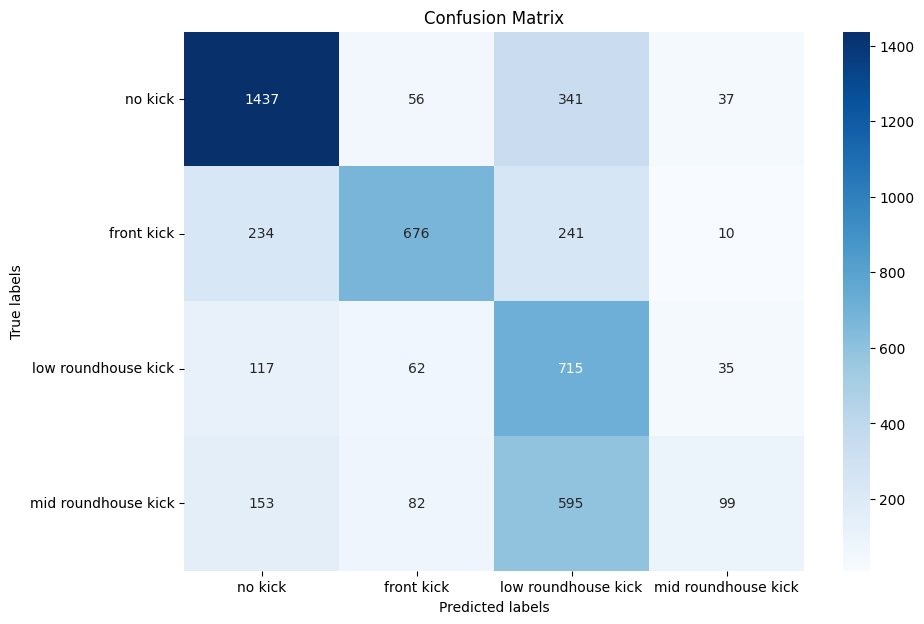

In [44]:
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
label_mapping = {0: "no kick", 1: "front kick", 2: "low roundhouse kick", 3: "mid roundhouse kick"}
label_mapping_str = {idx: label_mapping[label] for idx, label in enumerate(range(len(cm)))}


cm_df = pd.DataFrame(cm, index=label_mapping.values(), columns=label_mapping.values())

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [57]:
from sklearn.metrics import classification_report


y_pred = np.argmax(model.predict(X_test), axis=1)

class_names = ["no kick", "front kick", "low roundhouse kick", "mid roundhouse kick"]
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

print("Classification Report:")
print(report)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
{'no kick': {'precision': 0.740340030911901, 'recall': 0.7680384820951363, 'f1-score': 0.7539349422875131, 'support': 1871.0}, 'front kick': {'precision': 0.771689497716895, 'recall': 0.5822566752799311, 'f1-score': 0.6637211585665194, 'support': 1161.0}, 'low roundhouse kick': {'precision': 0.37790697674418605, 'recall': 0.7696447793326158, 'f1-score': 0.5069124423963134, 'support': 929.0}, 'mid roundhouse kick': {'precision': 0.5469613259668509, 'recall': 0.10656620021528525, 'f1-score': 0.1783783783783784, 'support': 929.0}, 'accuracy': 0.5985685071574642, 'macro avg': {'precision': 0.6092244578349582, 'recall': 0.556626534230742, 'f1-score': 0.525736730407181, 'support': 4890.0}, 'weighted avg': {'precision': 0.642190257240089, 'recall': 0.5985685071574642, 'f1-score': 0.576242886424408, 'support': 4890.0}}


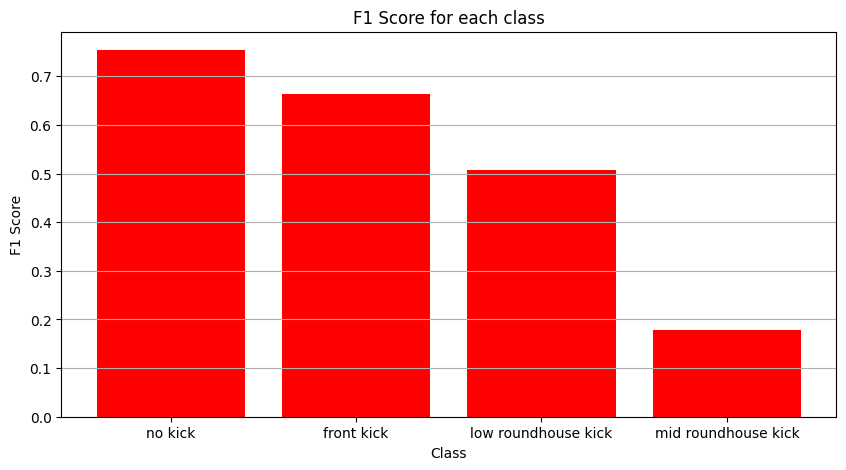

In [62]:
f1_scores = [report[str(class_name)]['f1-score'] for class_name in class_names]

f1_scores_array = np.array(f1_scores)

plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores_array)), f1_scores_array, color='red')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for each class')
plt.xticks(range(len(f1_scores_array)), label_mapping.values())
plt.grid(axis='y')
plt.show()

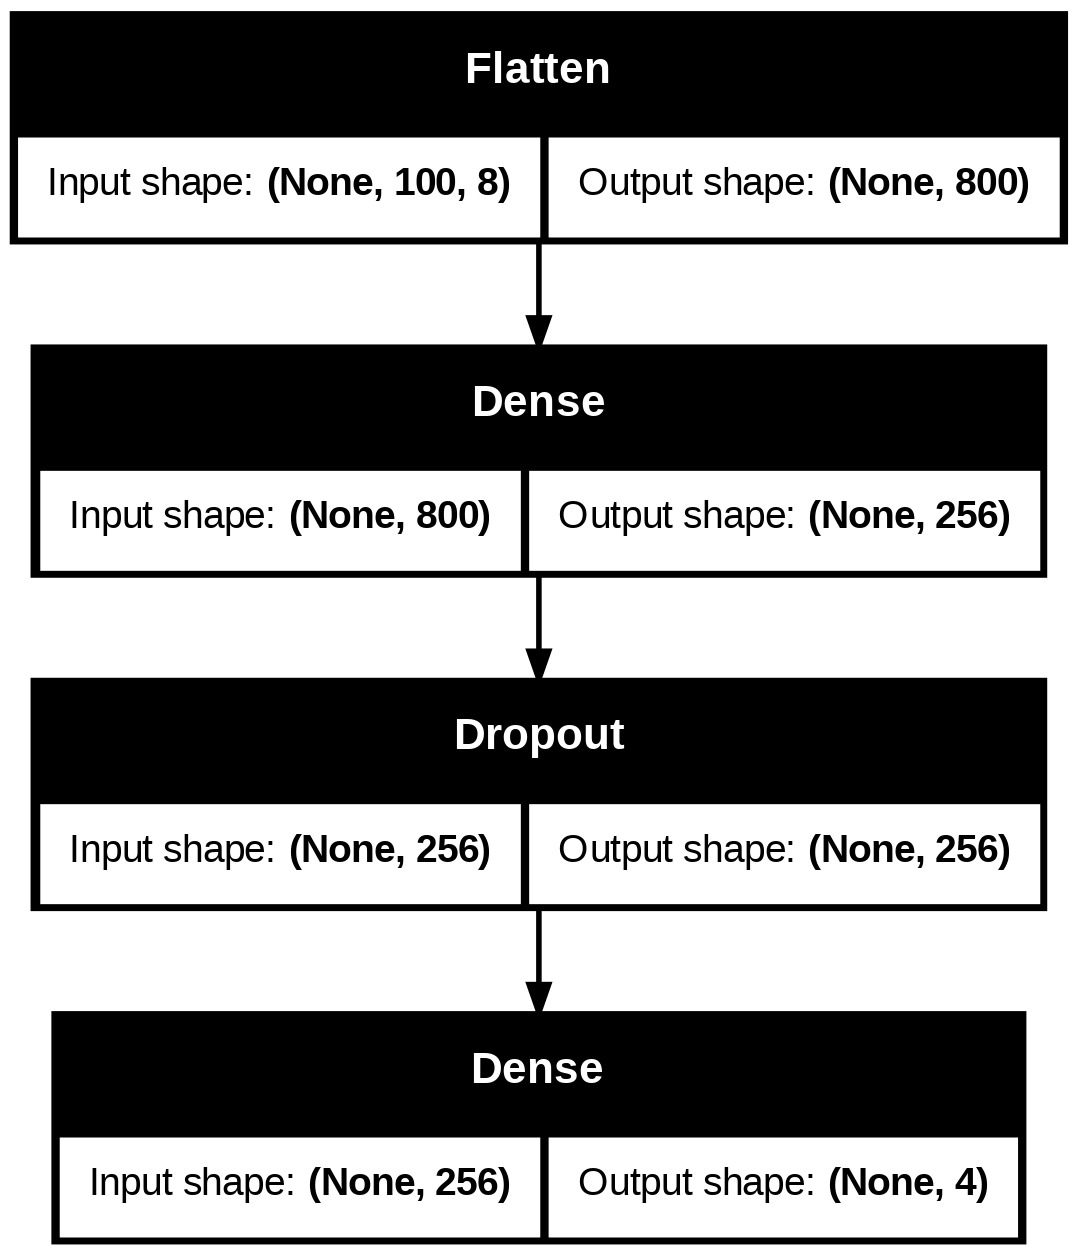

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# def lr_schedule(epoch):
#     initial_lr = 0.001
#     decay_factor = 0.1

#     if epoch < 20:
#         return initial_lr
#     else:
#         return initial_lr * (decay_factor ** (epoch // 10))

# lr_scheduler = LearningRateScheduler(lr_schedule)

# model = Sequential([
#     Flatten(input_shape=(5, 8)),
#     Dense(64, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(4, activation='softmax')
# ])
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# history = model.fit(X_train, y_train,
#                     epochs=30,
#                     batch_size=16,
#                     validation_data=(X_test, y_test),
#                     callbacks=[lr_scheduler])


# test_loss, test_accuracy = model.evaluate(X_test, y_test)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Input
# from tensorflow.keras.callbacks import LearningRateScheduler
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.optimizers import Adam

# def lr_schedule(epoch):
#     initial_lr = 0.001
#     decay_factor = 0.1

#     if epoch < 20:
#         return initial_lr
#     else:
#         return initial_lr * (decay_factor ** (epoch // 10))

# lr_scheduler = LearningRateScheduler(lr_schedule)

